### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pixelcnn import PixelCNN, ConditionalPixelCNN, PixelCNNPlusPlus
from utils import get_dataloaders, PadTransform, UnpadTransform, train_model, plot_batch

### Loading the data

In [4]:
train_data = pd.read_csv('data/train_small_grids.csv')
train_data

,Unnamed: 0,sample_id,input,output,input_grid_width,input_grid_height,output_grid_width,output_grid_height
0,0,007bbfb7,"[[7, 0, 7], [7, 0, 7], [7, 7, 0]]","[[7, 0, 7, 0, 0, 0, 7, 0, 7], [7, 0, 7, 0, 0, ...",3,3,9,9
1,1,007bbfb7,"[[0, 7, 7], [7, 7, 7], [0, 7, 7]]","[[0, 0, 0, 0, 7, 7, 0, 7, 7], [0, 0, 0, 7, 7, ...",3,3,9,9
2,2,007bbfb7,"[[4, 0, 4], [0, 0, 0], [0, 4, 0]]","[[4, 0, 4, 0, 0, 0, 4, 0, 4], [0, 0, 0, 0, 0, ...",3,3,9,9
3,3,007bbfb7,"[[0, 0, 0], [0, 0, 2], [2, 0, 2]]","[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, ...",3,3,9,9
4,4,007bbfb7,"[[6, 6, 0], [6, 0, 0], [0, 6, 6]]","[[6, 6, 0, 6, 6, 0, 0, 0, 0], [6, 0, 0, 6, 0, ...",3,3,9,9
...,...,...,...,...,...,...,...,...
920,1693,ff28f65a,"[[0, 0, 0, 0, 0, 0], [0, 2, 2, 0, 0, 0], [0, 2...","[[1, 0, 1], [0, 0, 0], [0, 0, 0]]",6,6,3,3
921,1694,ff28f65a,"[[0, 0, 0], [0, 2, 2], [0, 2, 2]]","[[1, 0, 0], [0, 0, 0], [0, 0, 0]]",3,3,3,3
922,1695,ff28f65a,"[[0, 0, 0, 0, 2, 2, 0], [0, 0, 0, 0, 2, 2, 0],...","[[1, 0, 1], [0, 1, 0], [1, 0, 0]]",7,7,3,3
923,1696,ff28f65a,"[[0, 0, 0, 0, 2, 2, 0], [0, 2, 2, 0, 2, 2, 0],...","[[1, 0, 1], [0, 1, 0], [1, 0, 1]]",7,7,3,3


### Verifying transforms

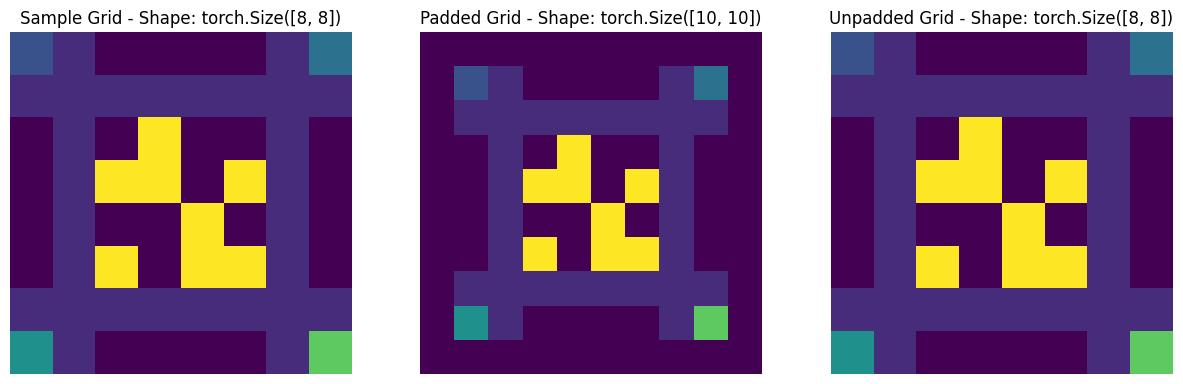

In [5]:
# Define the transforms
pad_transform = PadTransform((10, 10))
unpad_transform = UnpadTransform()

# pick a random sample from the training data
random_sample_idx = torch.randint(0, len(train_data), (1,)).item()

sample_grid = train_data.iloc[random_sample_idx]['input']
sample_grid_tensor = torch.tensor(eval(sample_grid), dtype=torch.float32)

sample_grid_padded = pad_transform(sample_grid_tensor)
orig_grid = unpad_transform(sample_grid_padded, sample_grid_tensor.shape)

# subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sample_grid_tensor.numpy())
axs[0].set_title(f'Sample Grid - Shape: {sample_grid_tensor.shape}')
axs[0].axis('off')

axs[1].imshow(sample_grid_padded.numpy())
axs[1].set_title(f'Padded Grid - Shape: {sample_grid_padded.shape}')
axs[1].axis('off')

axs[2].imshow(orig_grid.numpy())
axs[2].set_title(f'Unpadded Grid - Shape: {orig_grid.shape}')
axs[2].axis('off')

plt.show()

### PixelCNN

In [75]:
model = ConditionalPixelCNN(num_channels=10, filters=64, num_layers=7)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, threshold=0.001, factor=0.1)
dataset_variation = "ARC-AGI-smaller-grids"
wandb_project = "pixelcnn"
architecture = "conditional_pixelcnn"
epochs = 100

train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs,
    criterion,
    optimizer,
    scheduler=scheduler,
    dataset_variation=dataset_variation,
    architecture=architecture,
    wandb_project="pixelcnn"
)

Validation Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00, 13.57batch/s, CE Loss=1.63, Pixel Accuracy=82.68 %, Grid accuracy=0.00 %]


epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
train_grid_accuracy,▁█▆▆▆▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
train_loss,█▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pixel_accuracy,▁▆▇▇█▄▇█████████████████████████████████
val_grid_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_pixel_accuracy,▁███████████████████████████████████████
epoch,100
train_grid_accuracy,75
train_loss,1.64557
train_pixel_accuracy,81.32027


In [76]:
model = PixelCNN(num_channels=10, filters=64, num_layers=7)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, threshold=0.001, factor=0.1)
dataset_variation = "ARC-AGI-smaller-grids"
wandb_project = "pixelcnn"
architecture = "pixelcnn"
epochs = 100

train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs,
    criterion,
    optimizer,
    scheduler=scheduler,
    dataset_variation=dataset_variation,
    architecture=architecture,
    wandb_project="pixelcnn"
)

Validation Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00, 22.09batch/s, CE Loss=1.63, Pixel Accuracy=82.68 %, Grid accuracy=0.00 %]


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
train_grid_accuracy,▅▁▁▁▅▅▅▅▁▅▁█▅▁▁▁▁▅▅▅▅▁▅▅▁▅▁▅▅▅█▅▁██▅▅▅▅▅
train_loss,█▆▅▆▅▃▂▄▂▃▁▄▄▁▄▃▁▃▃▅▃▁▃▁▂▂▁▆▁▅▁▃▂▁▃▄▂▂▃▁
train_pixel_accuracy,▁▇██████████████████████████████████████
val_grid_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▅█▅▃▁▂▃▃▂▂▂▂▂▃▃▂▃▂▂▂▁▂▃▁▂▂▃▁▂▂▂▂▂▂▂▂▂▁▁
val_pixel_accuracy,▁▇█▇████████████████████████████████████
epoch,100
train_grid_accuracy,75
train_loss,1.64262
train_pixel_accuracy,81.47973


In [ ]:
model = PixelCNNPlusPlus(input_channels=1, n_classes=10, hidden_channels=64, num_layers=12)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, threshold=0.001, factor=0.1)
dataset_variation = "ARC-AGI-smaller-grids"
wandb_project = "pixelcnn"
architecture = "pixelcnn_plusplus"
epochs = 100

train_model(
    model,
    train_dataloader,
    val_dataloader,
    epochs,
    criterion,
    optimizer,
    scheduler=scheduler,
    dataset_variation=dataset_variation,
    architecture=architecture,
    wandb_project=wandb_project
)

Validation Epoch 100/100: 100%|██████████| 6/6 [00:00<00:00, 21.95batch/s, CE Loss=0.799, Pixel Accuracy=82.32 %, Grid accuracy=0.00 %]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_grid_accuracy,▁▁▁▁▁▁▁▁▁▁▆▃▆▆▃█████████████████████████
train_loss,█▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
train_pixel_accuracy,▁▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇████████████████████████
val_grid_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▂▂▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▂▃▃▃▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃
val_pixel_accuracy,▅▅▅▅▅▇▇██▃▆▃▅▃▂▁▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,100
train_grid_accuracy,0.81081
train_loss,0.60988
train_pixel_accuracy,83.19189


### Inference

In [48]:
test_data = pd.read_csv('../data/eval_small_grids.csv')
test_dataloader, _ = get_dataloaders(test_data, val_split=0.0, batch_size=32, transform=PadTransform((10, 10)), shuffle=False)

Train dataset size: 544
Validation dataset size: 0


In [80]:
# load the models
conditional_pixelcnn = ConditionalPixelCNN(num_channels=10, filters=64, num_layers=7)
conditional_pixelcnn.load_state_dict(torch.load("conditional_pixelcnn_100epochs_lr0.001.pth", weights_only=True))

pixelcnn = PixelCNN(num_channels=10, filters=64, num_layers=7)
pixelcnn.load_state_dict(torch.load("pixelcnn_100epochs_lr0.001.pth", weights_only=True))

pixelcnn_plusplus = PixelCNNPlusPlus(input_channels=1, n_classes=10, hidden_channels=64)
pixelcnn_plusplus.load_state_dict(torch.load("pixelcnn_plusplus_100epochs_lr0.001.pth", weights_only=True))

<All keys matched successfully>

In [104]:
torch.eq(targets.squeeze(), 0).sum().item() / 3200.

0.815625


ConditionalPixelCNN
--------------------------------------------------
Pixel accuracy: 69.81 %
Grid accuracy: 0.00 %
Background accuracy: 100.00 %
Foreground accuracy: 0.00 %

PixelCNN
--------------------------------------------------
Pixel accuracy: 69.75 %
Grid accuracy: 0.00 %
Background accuracy: 99.82 %
Foreground accuracy: 0.21 %

PixelCNNPlusPlus
--------------------------------------------------
Pixel accuracy: 70.66 %
Grid accuracy: 0.00 %
Background accuracy: 96.64 %
Foreground accuracy: 10.56 %


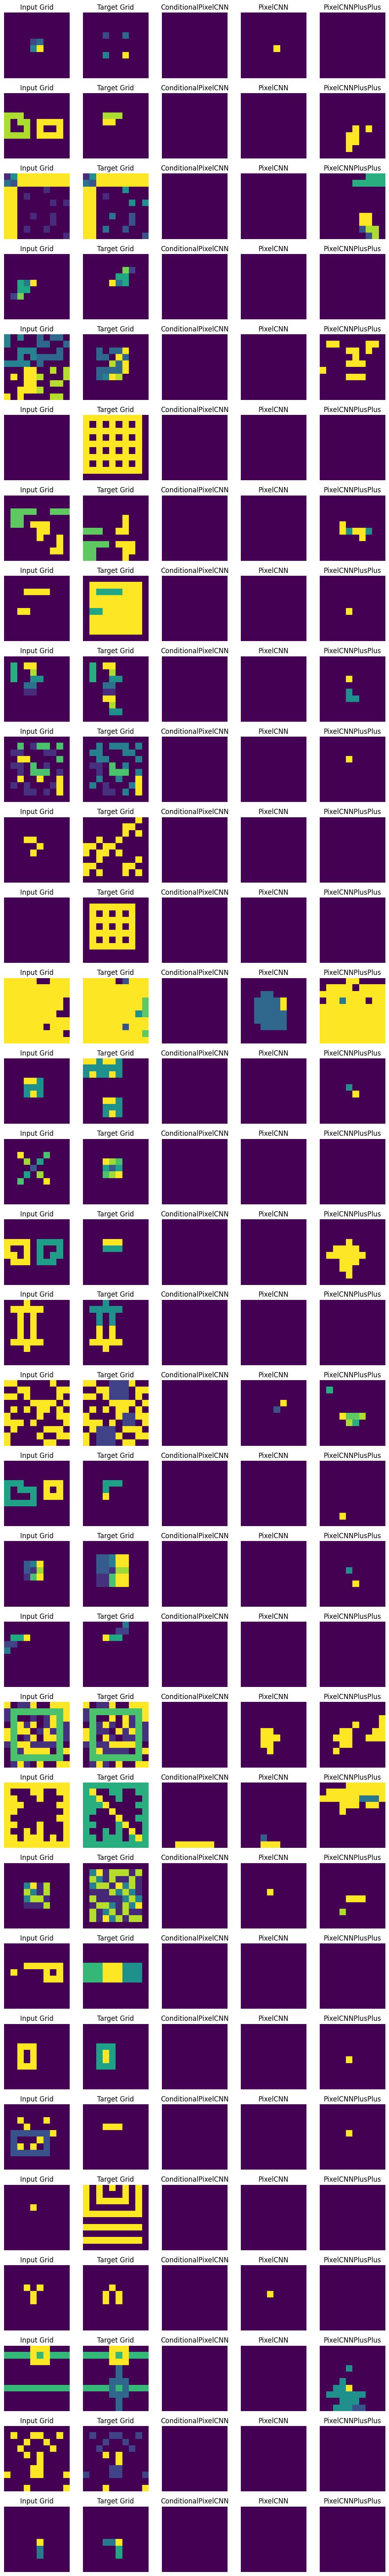

In [105]:
# Sample Inference with randomly selected samples from the test dataset
models = [conditional_pixelcnn, pixelcnn, pixelcnn_plusplus]
inputs, targets = next(iter(test_dataloader))
plot_batch(models, inputs, targets.squeeze())


ConditionalPixelCNN
--------------------------------------------------
Pixel accuracy: 81.56 %
Grid accuracy: 0.00 %

PixelCNN
--------------------------------------------------
Pixel accuracy: 81.75 %
Grid accuracy: 0.00 %

PixelCNNPlusPlus
--------------------------------------------------
Pixel accuracy: 82.88 %
Grid accuracy: 0.00 %


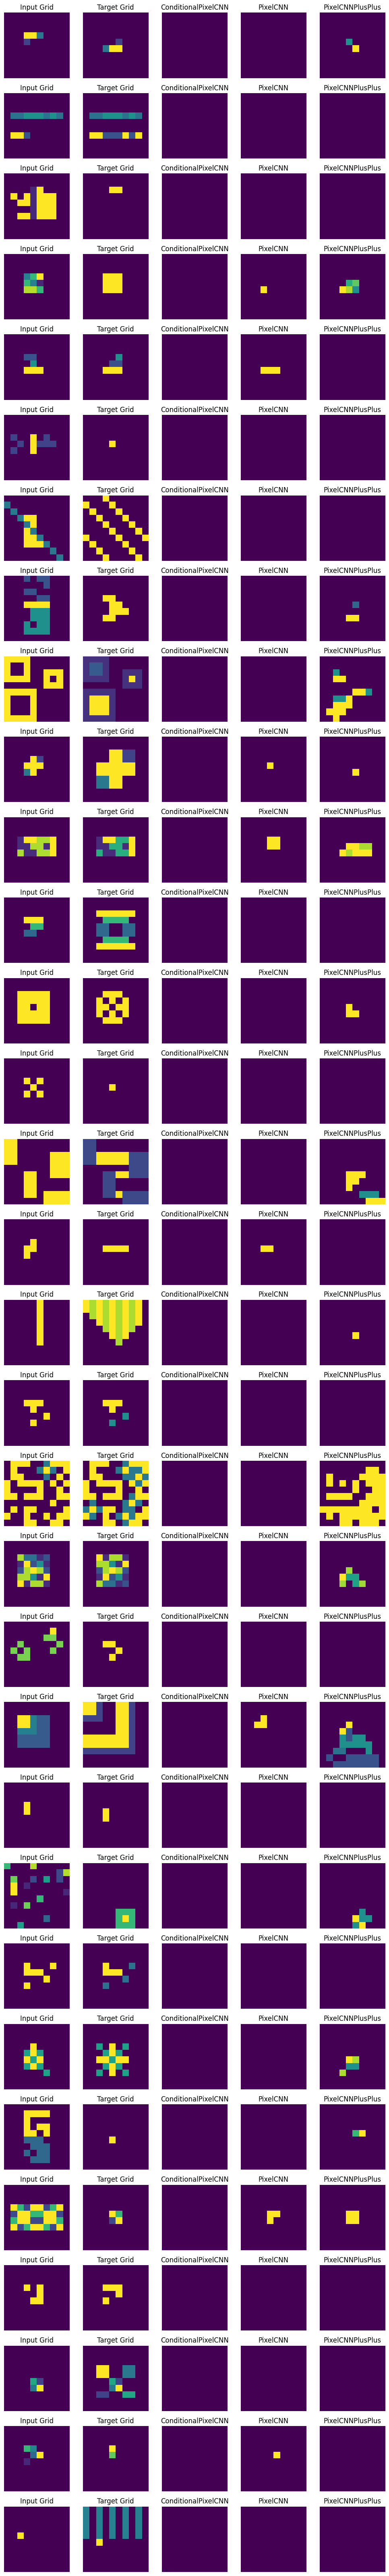

In [96]:
# Sample Inference with randomly selected samples from the train dataset
models = [conditional_pixelcnn, pixelcnn, pixelcnn_plusplus]
inputs, targets = next(iter(train_dataloader))
plot_batch(models, inputs, targets.squeeze())